# 関数のテスト

In [1]:
import sys
sys.path.append('/Users/LOng/sengokulab/LDAT_LS_2019/scripts/')

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import calc_variogram as variogram
import kriging_est as kriging

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')
data['price'] = np.log(data.price)

## Step1: OLSから残差を算出

In [5]:
# 前処理
x = data[['station', 'tokyo']]
y = data['price'].values

In [6]:
x = sm.add_constant(x).values
step1 = sm.OLS(y, x)
step1_res = step1.fit()
resid = step1_res.resid

/Users/LOng/sengokulab/LDAT_LS_2019/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
step1_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     9.803
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           0.000111
Time:                        10:54:26   Log-Likelihood:                 26.921
No. Observations:                 128   AIC:                            -47.84
Df Residuals:                     125   BIC:                            -39.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6572      0.273     46.363      0.000      12.117      13.198
x1           -20.7934      4.698     -4.426      0.000     -30.092     -11.495
x2            -0.7842      0.743     -1.056      0.293      -2.254       0.686
==============================================================================
Omnibus:                        4.618   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                4.368
Skew:                           0.452   Prob(JB):                        0.113
Kurtosis:                       3.049   Cond. No.                         284.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step2: 残差からvariogramを推定

In [8]:
# 前処理
resid = pd.DataFrame(resid, columns=['residuals'])
resid = data[['px', 'py']].join(resid)
resid = resid.values

In [9]:
resid

array([[ 1.39362310e+02,  3.57338500e+01, -1.78101794e-01],
       [ 1.39363027e+02,  3.56540780e+01, -4.20838794e-02],
       [ 1.39367082e+02,  3.56598590e+01,  1.54801037e-01],
       [ 1.39369003e+02,  3.56455460e+01, -1.95988429e-01],
       [ 1.39371526e+02,  3.56473230e+01, -1.81487357e-01],
       [ 1.39373562e+02,  3.57275950e+01, -1.05291399e-01],
       [ 1.39374415e+02,  3.56732410e+01,  4.37222276e-02],
       [ 1.39374691e+02,  3.56539720e+01,  5.77931962e-02],
       [ 1.39375802e+02,  3.56629740e+01,  2.76296629e-01],
       [ 1.39377419e+02,  3.56685930e+01,  2.73331150e-01],
       [ 1.39379504e+02,  3.56789730e+01,  9.78730372e-02],
       [ 1.39379862e+02,  3.56816580e+01, -8.14367626e-02],
       [ 1.39380375e+02,  3.56544240e+01,  9.57484164e-02],
       [ 1.39380871e+02,  3.57220070e+01, -7.21001836e-02],
       [ 1.39382431e+02,  3.56486010e+01, -1.45805602e-01],
       [ 1.39382461e+02,  3.56530610e+01,  6.93285719e-03],
       [ 1.39385678e+02,  3.56714310e+01

In [10]:
vario = variogram.get_diff(resid)

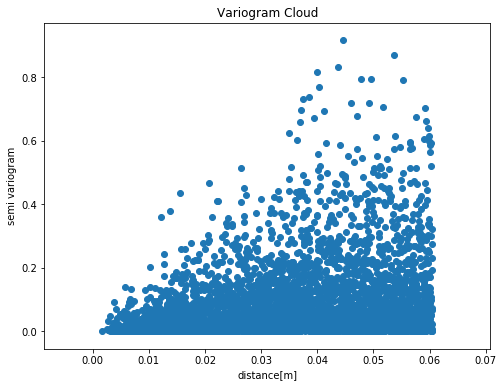

In [45]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vario[0], vario[1])
ax.set_title('Variogram Cloud')
ax.set_xlabel('distance[m]')
ax.set_ylabel('semi variogram')
fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/vario_cloud.png')

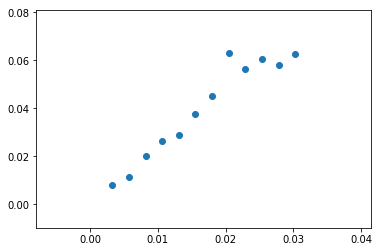

In [12]:
e_vario, count = variogram.emp_variogram(vario, 12)
plt.scatter(e_vario[0], e_vario[1])

[0.         0.00369736 0.00739472 0.01109208 0.01478944 0.0184868
 0.02218416 0.02588152 0.02957888 0.03327625]
0.14995212615072695 0.051370220165630455


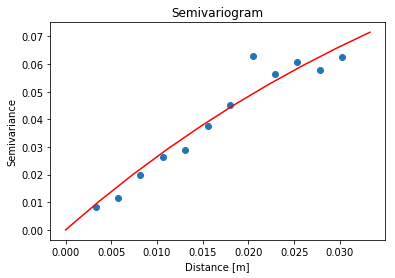

In [16]:
param, fig = variogram.auto_vario(resid, 12, 2)

In [17]:
print(param)

[2.00000000e+00 1.00000000e+02 1.49952126e-01 5.13702202e-02]


## Step3: gls
- 共分散関数を推定
    - 観測値間の距離行列を作成
    - 推定したパラメータから$\hat{C}(0)$を推定
    - 正定値になるように処理を加える(数学的な根拠は不明, Rではどのように処理している?)
- 共分散関数の推定量を用いてgls

In [18]:
distance_mat = kriging.calc_distance_matrix(data, ['px', 'py'])

In [19]:
efrange, c0 = kriging.calc_c0(param, distance_mat)

In [20]:
print(efrange)

0.15411066049689137


In [21]:
print(c0)

0.007465676756572802


In [27]:
# 距離行列と関数形から共分散関数を求める
# reg=Trueなので正定値化処理を加えている
covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)

0.1382660312608774


In [28]:
print(covariance_mat)

[[0.14573171 0.03173338 0.03540934 ... 0.00879541 0.00919129 0.00975951]
 [0.03173338 0.14573171 0.1306936  ... 0.02028977 0.02010128 0.01960327]
 [0.03540934 0.1306936  0.14573171 ... 0.02119259 0.02112918 0.02079818]
 ...
 [0.00879541 0.02028977 0.02119259 ... 0.14573171 0.13604639 0.11728449]
 [0.00919129 0.02010128 0.02112918 ... 0.13604639 0.14573171 0.12927184]
 [0.00975951 0.01960327 0.02079818 ... 0.11728449 0.12927184 0.14573171]]


In [29]:
# 重みを用いてgls
# statsmodelsのresultクラスが返る
res, resid = kriging.do_gls(y, x, covariance_mat)

In [30]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.953
Model:                            GLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1259.
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           1.48e-83
Time:                        15:45:02   Log-Likelihood:                 101.84
No. Observations:                 128   AIC:                            -197.7
Df Residuals:                     125   BIC:                            -189.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3919      1.156     11.581      0.000      11.103      15.680
x1           -19.3614      3.319     -5.833      0.000     -25.931     -12.792
x2            -3.1629      3.194     -0.990      0.324      -9.483       3.158
==============================================================================
Omnibus:                       20.304   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.538
Skew:                           0.580   Prob(JB):                     1.75e-11
Kurtosis:                       5.818   Cond. No.                         20.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step4: kirigng
- 観測地点と予測地点の間の共分散関数$c_*$を作成する
    - 距離行列作成
    - 共分散関数にあてはめる
- 足し合わせ $\hat{Y}(s_o) = X(s_0)\hat{\beta}_{gls} + c_*'\hat{\Sigma}^{-1}(Y - X\beta)$

In [31]:
# 前処理
mdat = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_pred.csv')
mdat.head()

,px,py,price,station,tokyo
0,139.402984,35.767626,NaN,0.017537,0.374249
1,139.407036,35.767626,NaN,0.013571,0.370307
2,139.411089,35.767626,NaN,0.009675,0.366367
3,139.439457,35.767626,NaN,0.001584,0.338865
4,139.394878,35.763700,NaN,0.026327,0.381271


In [32]:
mpoints = mdat[['px', 'py']].values 
mexog = mdat[['station', 'tokyo']]
mexog = sm.add_constant(mexog).values

/Users/LOng/sengokulab/LDAT_LS_2019/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [33]:
points = data[['px', 'py']].values

In [34]:
# 距離行列作成
new_dist_mat = kriging.calc_distance_new_data(mpoints, points)

In [35]:
# 距離行列と関数型から共分散行列を推定
# reg=Falseを指定して正定値処理をスキップ(正方行列でないのでエラーを防ぐ)
c_mat = kriging.est_covariance_matrix(new_dist_mat, param, c0, reg=False)

In [36]:
fitted_val = kriging.put_pred_val(res, mexog)

In [37]:
kriging_val = kriging.do_kriging(fitted_val, c_mat, covariance_mat, resid)

## Rでの結果との比較

In [38]:
res_inR = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/krig_res_R.csv')
res_inR = res_inR.iloc[:, 1:-2]

Text(0, 0.5, 'pred by Python')

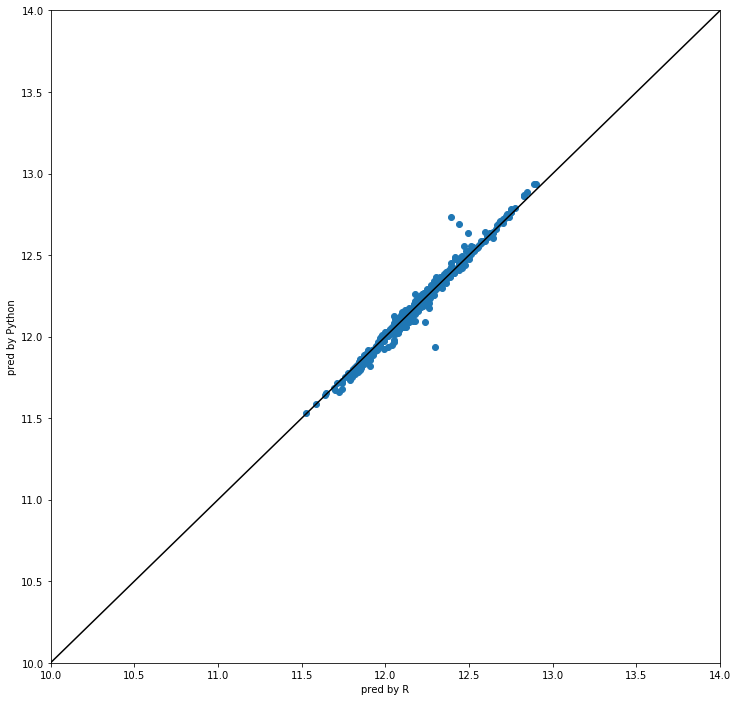

In [39]:
res_fig = plt.figure(figsize=(12, 12))
res_ax = res_fig.add_subplot(1, 1, 1)
res_ax.scatter(res_inR['var1.pred'], kriging_val)
res_ax.plot(np.linspace(10, 14, 1000), np.linspace(10, 14, 1000), color='black')
res_ax.set_xlim(10, 14)
res_ax.set_ylim(10, 14)
res_ax.set_xlabel('pred by R')
res_ax.set_ylabel('pred by Python')

In [77]:
res_fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/kriging_est_func_res2.png')